In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow import keras
from zipfile import ZipFile
import keras.backend as k
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from PIL import Image

In [3]:
# Image.open('../input/carvana-image-masking-challenge/29bb3ece3180_11.jpg')

In [4]:
train_zip = '../input/carvana-image-masking-challenge/train.zip'
with ZipFile(train_zip, 'r') as zip_:
    zip_.extractall('/kaggle/working')
    
train_masks_zip = '../input/carvana-image-masking-challenge/train_masks.zip'
with ZipFile(train_masks_zip, 'r') as zip_:
    zip_.extractall('/kaggle/working')

In [5]:
car_ids = []
paths = []

for dirname, _, filenames in os.walk('./train'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        paths.append(path)
        
        car_id = filename.split('.')[0]
        car_ids.append(car_id)
        
d = {'id' : car_ids, 'path': paths}
df = pd.DataFrame(data = d)
df = df.set_index('id')
# df.head()

mask_ids = []
mask_paths = []

for dirname, _, filenames in os.walk('./train_masks'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        mask_paths.append(path)
        
        mask_id = filename.split('.')[0]
        mask_id = mask_id.split('_mask')[0]
        mask_ids.append(mask_id)
        
dic = {'id' : mask_ids, 'mask_path': mask_paths}
mask_df = pd.DataFrame(data = dic)
mask_df = mask_df.set_index('id')
mask_df.head()

,mask_path
id,
5d95d80e10a9_03,./train_masks/5d95d80e10a9_03_mask.gif
430f0cb5666c_12,./train_masks/430f0cb5666c_12_mask.gif
1b25ea8ba94d_15,./train_masks/1b25ea8ba94d_15_mask.gif
0d3adbbc9a8b_14,./train_masks/0d3adbbc9a8b_14_mask.gif
528eb34a4c29_01,./train_masks/528eb34a4c29_01_mask.gif


In [6]:
df.head()

,path
id,
f7ad86e13ed7_11,./train/f7ad86e13ed7_11.jpg
9a2bfb24ba6e_15,./train/9a2bfb24ba6e_15.jpg
ae296a20fdd9_11,./train/ae296a20fdd9_11.jpg
1a17a1bd648b_06,./train/1a17a1bd648b_06.jpg
6f6dced498c4_15,./train/6f6dced498c4_15.jpg


In [7]:
df['mask_path'] = mask_df['mask_path']
df.head()

,path,mask_path
id,,
f7ad86e13ed7_11,./train/f7ad86e13ed7_11.jpg,./train_masks/f7ad86e13ed7_11_mask.gif
9a2bfb24ba6e_15,./train/9a2bfb24ba6e_15.jpg,./train_masks/9a2bfb24ba6e_15_mask.gif
ae296a20fdd9_11,./train/ae296a20fdd9_11.jpg,./train_masks/ae296a20fdd9_11_mask.gif
1a17a1bd648b_06,./train/1a17a1bd648b_06.jpg,./train_masks/1a17a1bd648b_06_mask.gif
6f6dced498c4_15,./train/6f6dced498c4_15.jpg,./train_masks/6f6dced498c4_15_mask.gif


In [8]:
img_size = [256,256]

def data_augmentation(car_img, mask_img):
    if tf.random.uniform(()) > 0.5:
        car_img = tf.image.flip_left_right(car_img)
        mask_img = tf.image.flip_left_right(mask_img)
    return car_img, mask_img

def preprocessing(car_path, mask_path):
    car_img = tf.io.read_file(car_path)
    car_img = tf.image.decode_jpeg(car_img, channels = 3)
    car_img = tf.image.resize(car_img, img_size)
    car_img = tf.cast(car_img, tf.float32)/255.0
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels = 3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]
    mask_img = tf.math.sign(mask_img)
    
    return car_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df['path'].values, df['mask_path'].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df['path'].values, df['mask_path'].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)
        
    return ds
        

In [9]:
train_df, valid_df = train_test_split(df, random_state = 42, test_size= 0.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)

In [10]:
train_length = len(train_df)
buffer = 1000
batch_size = 16

In [11]:
train_dataset = train.cache().shuffle(buffer).batch(batch_size).repeat()
train_dataset = train_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
valid_dataset = valid.batch(batch_size)

In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [13]:
for i in range(5):
    for image, mask in train.take(i):
        sample_image, sample_mask = image, mask
#         display([sample_image, sample_mask])

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape = [256,256,3], include_top = False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs = base_model.input, outputs = base_model_outputs)
down_stack.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [15]:
def upsample(filters, size, norm_type = 'batchnorm', apply_dropout = False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides = 2,
                            padding = 'same', kernel_initializer = initializer,
                            use_bias = False))
    
    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())
        
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        result.add(tf.keras.layers.ReLu())
    
    return result
        
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape = [256,256,3])
    
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
        
    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides = 2, activation= 'sigmoid', padding = 'same')
    
    x = last(x)
    
    return tf.keras.Model(inputs = inputs, outputs = x)

In [17]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = k.sum(y_true * y_pred, axis=[1,2,3])
    union = k.sum(y_true, axis=[1,2,3]) + k.sum(y_pred, axis=[1,2,3])
    return k.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

model = unet_model(1)

model.compile(optimizer = 'adam', loss = dice_loss, metrics = [dice_coef, 'binary_accuracy'])

# tf.keras.utils.plot_model(model, show_shapes = True)

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 128, 128, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 16, 16, 512)  1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 16, 16, 1088) 0           sequential[0][0]                 
                                                                 model[0][3]                

In [19]:
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break
        
def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])
    
# show_predictions(sample_image, sample_mask)


Epoch 1/15
238/238 [==============================] - 720s 3s/step - loss: 0.1425 - dice_coef: 0.8575 - binary_accuracy: 0.9501 - val_loss: 0.0327 - val_dice_coef: 0.9673 - val_binary_accuracy: 0.9887
Epoch 2/15
238/238 [==============================] - 682s 3s/step - loss: 0.0253 - dice_coef: 0.9747 - binary_accuracy: 0.9909 - val_loss: 0.0226 - val_dice_coef: 0.9774 - val_binary_accuracy: 0.9916
Epoch 3/15


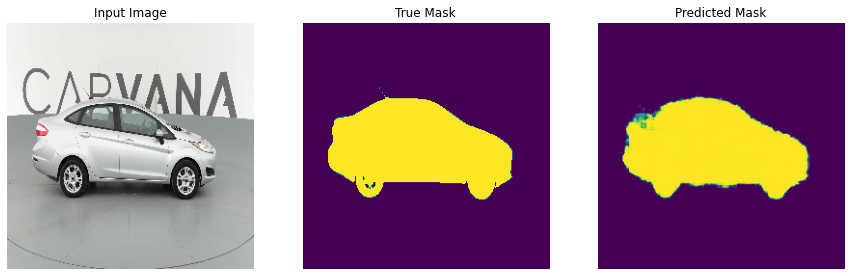

238/238 [==============================] - 684s 3s/step - loss: 0.0220 - dice_coef: 0.9780 - binary_accuracy: 0.9916 - val_loss: 0.0207 - val_dice_coef: 0.9793 - val_binary_accuracy: 0.9920
Epoch 4/15
238/238 [==============================] - 676s 3s/step - loss: 0.0205 - dice_coef: 0.9795 - binary_accuracy: 0.9920 - val_loss: 0.0200 - val_dice_coef: 0.9800 - val_binary_accuracy: 0.9922
Epoch 5/15
238/238 [==============================] - 679s 3s/step - loss: 0.0197 - dice_coef: 0.9803 - binary_accuracy: 0.9922 - val_loss: 0.0198 - val_dice_coef: 0.9802 - val_binary_accuracy: 0.9922
Epoch 6/15


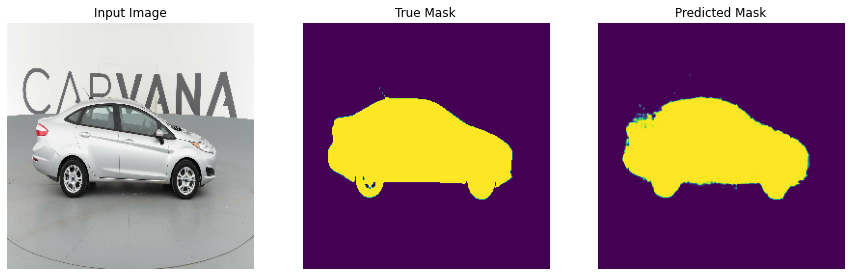

238/238 [==============================] - 682s 3s/step - loss: 0.0190 - dice_coef: 0.9810 - binary_accuracy: 0.9924 - val_loss: 0.0190 - val_dice_coef: 0.9810 - val_binary_accuracy: 0.9924
Epoch 7/15
238/238 [==============================] - 682s 3s/step - loss: 0.0184 - dice_coef: 0.9816 - binary_accuracy: 0.9926 - val_loss: 0.0190 - val_dice_coef: 0.9810 - val_binary_accuracy: 0.9924
Epoch 8/15
238/238 [==============================] - 691s 3s/step - loss: 0.0181 - dice_coef: 0.9819 - binary_accuracy: 0.9926 - val_loss: 0.0185 - val_dice_coef: 0.9815 - val_binary_accuracy: 0.9925
Epoch 9/15


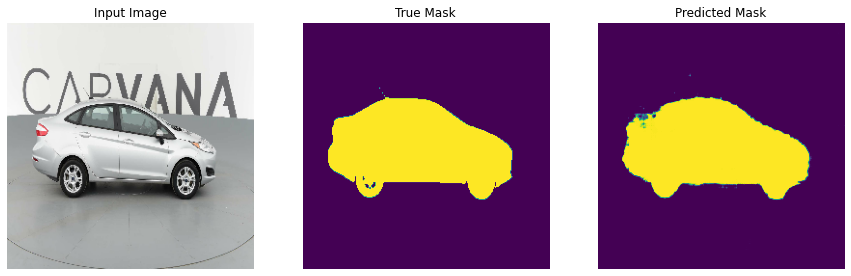

238/238 [==============================] - 679s 3s/step - loss: 0.0179 - dice_coef: 0.9821 - binary_accuracy: 0.9927 - val_loss: 0.0185 - val_dice_coef: 0.9815 - val_binary_accuracy: 0.9925
Epoch 10/15
238/238 [==============================] - 686s 3s/step - loss: 0.0175 - dice_coef: 0.9824 - binary_accuracy: 0.9928 - val_loss: 0.0186 - val_dice_coef: 0.9814 - val_binary_accuracy: 0.9924
Epoch 11/15
238/238 [==============================] - 688s 3s/step - loss: 0.0171 - dice_coef: 0.9828 - binary_accuracy: 0.9930 - val_loss: 0.0184 - val_dice_coef: 0.9815 - val_binary_accuracy: 0.9924
Epoch 12/15


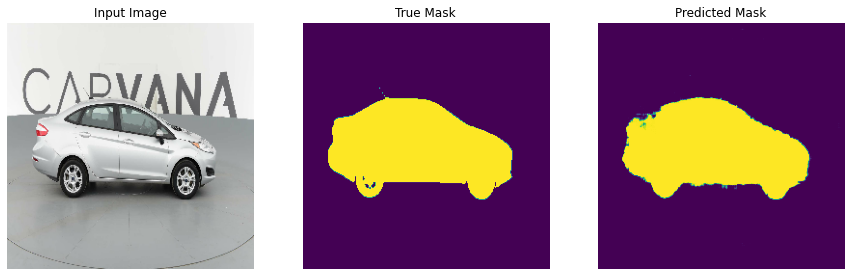

238/238 [==============================] - 686s 3s/step - loss: 0.0170 - dice_coef: 0.9830 - binary_accuracy: 0.9930 - val_loss: 0.0182 - val_dice_coef: 0.9818 - val_binary_accuracy: 0.9925
Epoch 13/15
238/238 [==============================] - 682s 3s/step - loss: 0.0169 - dice_coef: 0.9830 - binary_accuracy: 0.9930 - val_loss: 0.0178 - val_dice_coef: 0.9822 - val_binary_accuracy: 0.9927
Epoch 14/15
238/238 [==============================] - 685s 3s/step - loss: 0.0166 - dice_coef: 0.9834 - binary_accuracy: 0.9932 - val_loss: 0.0179 - val_dice_coef: 0.9820 - val_binary_accuracy: 0.9926
Epoch 15/15


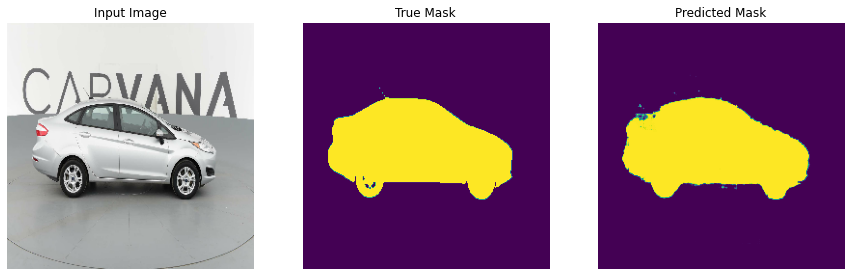

238/238 [==============================] - 691s 3s/step - loss: 0.0166 - dice_coef: 0.9834 - binary_accuracy: 0.9931 - val_loss: 0.0177 - val_dice_coef: 0.9823 - val_binary_accuracy: 0.9927


In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

class DisplayCallBacks(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epochs, logs = None):
        if (epochs + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)
            
            
epochs = 15
steps_per_epochs = train_length//batch_size

model_history = model.fit(train_dataset, epochs = epochs,
                         steps_per_epoch = steps_per_epochs,
                         validation_data = valid_dataset,
                         callbacks = [DisplayCallBacks(), early_stop])

In [21]:
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break
model.predict(sample_image[tf.newaxis, ...])

array([[[[1.3209821e-06],
         [9.2728741e-10],
         [2.0669190e-11],
         ...,
         [7.0426380e-05],
         [1.1618331e-05],
         [3.8301864e-06]],

        [[5.3792771e-08],
         [1.1368451e-09],
         [2.5800993e-12],
         ...,
         [1.7650440e-05],
         [1.9659490e-07],
         [1.1135492e-06]],

        [[8.0033784e-09],
         [7.6202530e-11],
         [3.2750972e-12],
         ...,
         [2.3482970e-07],
         [9.0211538e-10],
         [5.3928012e-10]],

        ...,

        [[1.8676778e-13],
         [3.0914721e-14],
         [1.5788931e-19],
         ...,
         [3.3170052e-15],
         [9.0042568e-21],
         [1.0221252e-13]],

        [[4.8412003e-17],
         [8.7796159e-21],
         [4.4196447e-26],
         ...,
         [3.5438789e-20],
         [5.2690229e-25],
         [2.8712253e-19]],

        [[2.6042467e-12],
         [6.5259985e-14],
         [1.0072453e-19],
         ...,
         [3.5718891e-14],
        